<a href="https://colab.research.google.com/github/nganduong31231023222-ai/BAITAPNHOM/blob/main/Cu%E1%BB%91i_k%E1%BB%B3_nh%C3%B3m_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q numpy pandas matplotlib seaborn scikit-learn umap-learn joblib scipy tqdm

In [ ]:
import os
import random
import warnings
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score
from sklearn.metrics import adjusted_rand_score
from sklearn.pipeline import Pipeline

import umap
import joblib
import scipy.cluster.hierarchy as sch
file_path = "./finale.csv"

# Đọc file CSV
df = pd.read_csv(file_path)
# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

warnings.filterwarnings('ignore')
print('Imports complete. Random seed:', RANDOM_STATE)



/home/lab/miniconda3/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/home/lab/miniconda3/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Imports complete. Random seed: 42


In [ ]:
preferred_numeric = ['investment_rounds', 'invested_companies', 'funding_rounds', 'funding_total_usd',
                     'milestones','relationships','raised_amount_usd',
                     'num_acquisizioni_effettuate','fin_org_financed',
                     'person_financed','startup_financed','num_prodotti']
num_cols = [c for c in preferred_numeric if c in df.columns]

# Cleaning step: detect & handle implausible outliers and missing data
print('Missing values before cleaning:\n', df.isna().sum())

# Define plausible ranges for numeric features and set out-of-range to NaN
plausible_ranges = {
    'investment_rounds': (10, 80),
    'invested_companies': (5, 40),
    'funding_rounds': (1, 10),
    'funding_total_usd': (1000, 1000000),
    'milestones': (1,10),
    'relationships': (1,100),
    'raised_amount_usd': (10000,10000000),
    'num_acquisizioni_effettuate': (1,10),
    'fin_org_financed': (1,100),
    'person_financed': (1,20),
    'startup_financed': (1,5),
    'num_prodotti': (1,5)
}
for col, (low, high) in plausible_ranges.items():
    if col in df.columns:
        bad_mask = (df[col] < low) | (df[col] > high)
        n_bad = int(bad_mask.sum())
        if n_bad > 0:
            print(f"Setting {n_bad} values in {col} outside [{low},{high}] to NaN")
            df.loc[bad_mask, col] = np.nan

# Drop rows that have all numeric features missing
num_cols = [c for c in preferred_numeric if c in df.columns]
before = df.shape[0]
df.dropna(subset=num_cols, how='all', inplace=True)
after = df.shape[0]
print(f'Dropped {before-after} rows with all numeric features missing')

print('Missing values after cleaning:\n', df.isna().sum())

# Show a brief summary
try:
    display(df[num_cols].describe())
except Exception:
    pass

Missing values before cleaning:
 id                               0
category_code                    0
status                           0
logo_width                       0
logo_height                      0
country_code                     0
investment_rounds                0
invested_companies               0
funding_rounds                   0
funding_total_usd                0
milestones                       0
relationships                    0
object_id                      110
raised_amount_usd                0
acquiring_object_id             18
num_acquisizioni_effettuate      0
acquired_object_id               1
funded_object_id_x               0
fin_org_financed                 0
funded_object_id_y              13
person_financed                  0
funded_object_id                18
startup_financed                 0
parent_id                        0
num_prodotti                     0
founded_year                     0
founded_month                    0
dtype: int64
Setting 1

Missing values before cleaning:
 id                               0
category_code                    0
status                           0
logo_width                       0
logo_height                      0
country_code                     0
investment_rounds                0
invested_companies               0
funding_rounds                   0
funding_total_usd                0
milestones                       0
relationships                    0
object_id                      110
raised_amount_usd                0
acquiring_object_id             18
num_acquisizioni_effettuate      0
acquired_object_id               1
funded_object_id_x               0
fin_org_financed                 0
funded_object_id_y              13
person_financed                  0
funded_object_id                18
startup_financed                 0
parent_id                        0
num_prodotti                     0
founded_year                     0
founded_month                    0
dtype: int64
Setting 1

,investment_rounds,invested_companies,funding_rounds,funding_total_usd,milestones,relationships,raised_amount_usd,num_acquisizioni_effettuate,fin_org_financed,person_financed,startup_financed,num_prodotti
count,55.000000,131.000000,31682.000000,9759.000000,91675.000000,129555.000000,1.251650e+05,4794.000000,17851.000000,4404.000000,4777.000000,10907.000000
mean,23.454545,10.572519,1.652894,361105.784097,1.199389,2.714600,2.279502e+06,1.583020,3.412974,2.878520,1.255390,1.725131
std,13.138603,7.793519,1.170914,312969.231196,0.540123,4.342945,2.669190e+06,1.317163,3.783745,2.835245,0.629473,1.115959
min,10.000000,5.000000,1.000000,1000.000000,1.000000,1.000000,1.000000e+04,1.000000,1.000000,1.000000,1.000000,1.000000
25%,14.000000,5.500000,1.000000,100000.000000,1.000000,1.000000,2.502500e+05,1.000000,1.000000,1.000000,1.000000,1.000000
50%,18.000000,7.000000,1.000000,253195.000000,1.000000,1.000000,1.061520e+06,1.000000,2.000000,2.000000,1.000000,1.000000
75%,30.000000,14.000000,2.000000,578446.000000,1.000000,3.000000,3.409316e+06,2.000000,4.000000,4.000000,1.000000,2.000000
max,68.000000,39.000000,10.000000,1000000.000000,9.000000,100.000000,1.000000e+07,10.000000,54.000000,20.000000,5.000000,5.000000


In [ ]:
# Cell: Data loading
DATA_PATH = 'finale.csv' if os.path.exists('finale.csv') else None  # default to local file if present
# Ensure rename_map exists (may be created earlier in other flows). Use empty dict as safe default.
rename_map = {}

try:
    if DATA_PATH and os.path.exists(DATA_PATH):
        df = pd.read_csv(DATA_PATH)
    else:
        import seaborn as sns
        df = sns.load_dataset('finale')
    print('Initial loaded dataset with shape:', df.shape)

    # Standardize missing-value markers and strip whitespace
    df.replace(['NA', 'NaN', '.', ''], np.nan, inplace=True)
    df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

    # Some CSVs may use slightly different names; add other candidates if needed
    if rename_map:
        df.rename(columns=rename_map, inplace=True)
        print('Renamed columns:', rename_map)

    # Coerce expected numeric columns to numeric dtype
    for col in ['investment_rounds', 'invested_companies', 'funding_rounds', 'funding_total_usd',
                     'milestones','relationships','raised_amount_usd',
                     'num_acquisizioni_effettuate','fin_org_financed',
                     'person_financed','startup_financed','num_prodotti',]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    print('Post-processed dataset shape:', df.shape)
    display(df.head())
    print('\nInfo:')
    print(df.info())
except Exception as e:
    print('Failed to load dataset:', e)
    print('Please download the CSV from the Kaggle link or place a local copy and set DATA_PATH.')

Initial loaded dataset with shape: (196498, 27)
Post-processed dataset shape: (196498, 27)
Post-processed dataset shape: (196498, 27)


Initial loaded dataset with shape: (196498, 27)
Post-processed dataset shape: (196498, 27)
Post-processed dataset shape: (196498, 27)


,id,category_code,status,logo_width,logo_height,country_code,investment_rounds,invested_companies,funding_rounds,funding_total_usd,...,funded_object_id_x,fin_org_financed,funded_object_id_y,person_financed,funded_object_id,startup_financed,parent_id,num_prodotti,founded_year,founded_month
0,1,web,operating,401,54,USA,0,0,3,39750000.0,...,1.0,9.0,NaN,0.0,NaN,0.0,1.0,2.0,2005.0,10.0
1,10,games_video,acquired,186,85,USA,0,0,0,0.0,...,1.0,0.0,NaN,0.0,NaN,0.0,10.0,1.0,2005.0,10.0
2,100,games_video,acquired,107,34,USA,0,0,0,0.0,...,1.0,0.0,NaN,0.0,NaN,0.0,10.0,0.0,2005.0,10.0
3,10000,network_hosting,operating,0,0,USA,0,0,0,0.0,...,1.0,0.0,NaN,0.0,NaN,0.0,10.0,0.0,2008.0,7.0
4,10001,games_video,operating,200,74,USA,0,0,0,0.0,...,1.0,0.0,NaN,0.0,NaN,0.0,10.0,0.0,2008.0,7.0


Initial loaded dataset with shape: (196498, 27)
Post-processed dataset shape: (196498, 27)
Post-processed dataset shape: (196498, 27)


,id,category_code,status,logo_width,logo_height,country_code,investment_rounds,invested_companies,funding_rounds,funding_total_usd,...,funded_object_id_x,fin_org_financed,funded_object_id_y,person_financed,funded_object_id,startup_financed,parent_id,num_prodotti,founded_year,founded_month
0,1,web,operating,401,54,USA,0,0,3,39750000.0,...,1.0,9.0,NaN,0.0,NaN,0.0,1.0,2.0,2005.0,10.0
1,10,games_video,acquired,186,85,USA,0,0,0,0.0,...,1.0,0.0,NaN,0.0,NaN,0.0,10.0,1.0,2005.0,10.0
2,100,games_video,acquired,107,34,USA,0,0,0,0.0,...,1.0,0.0,NaN,0.0,NaN,0.0,10.0,0.0,2005.0,10.0
3,10000,network_hosting,operating,0,0,USA,0,0,0,0.0,...,1.0,0.0,NaN,0.0,NaN,0.0,10.0,0.0,2008.0,7.0
4,10001,games_video,operating,200,74,USA,0,0,0,0.0,...,1.0,0.0,NaN,0.0,NaN,0.0,10.0,0.0,2008.0,7.0



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196498 entries, 0 to 196497
Data columns (total 27 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           196498 non-null  int64  
 1   category_code                196498 non-null  object 
 2   status                       196498 non-null  object 
 3   logo_width                   196498 non-null  int64  
 4   logo_height                  196498 non-null  int64  
 5   country_code                 196498 non-null  object 
 6   investment_rounds            196498 non-null  int64  
 7   invested_companies           196498 non-null  int64  
 8   funding_rounds               196498 non-null  int64  
 9   funding_total_usd            196498 non-null  float64
 10  milestones                   196498 non-null  int64  
 11  relationships                196498 non-null  int64  
 12  object_id                    196388 non-null  float

In [ ]:
# Feature selection and encoding (robust to alternate column names)
# Preferred numeric feature names (we attempted to rename culmen_* to bill_* on load)
preferred_numeric = ['investment_rounds', 'invested_companies', 'funding_rounds', 'funding_total_usd',
                     'milestones','relationships','raised_amount_usd',
                     'num_acquisizioni_effettuate','fin_org_financed',
                     'person_financed','startup_financed','num_prodotti']
numeric_features = [c for c in preferred_numeric if c in df.columns]

# Fallback: any numeric column
if not numeric_features:
    numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()

# Categorical features (optional)
cat_features = [c for c in ['island', 'sex'] if c in df.columns]

print('Numeric features available:', numeric_features)
print('Categorical features available:', cat_features)

# Build feature DataFrame - start with numeric
X_num = df[numeric_features].copy()
X_cat = df[cat_features].copy() if cat_features else None

# Simple encoding for categorical
if X_cat is not None:
    X_cat_encoded = pd.get_dummies(X_cat, dummy_na=True)
    X = pd.concat([X_num, X_cat_encoded], axis=1)
else:
    X = X_num.copy()

print('Feature matrix shape (before imputation):', X.shape)
try:
    display(X.head())
except Exception:
    pass

Numeric features available: ['investment_rounds', 'invested_companies', 'funding_rounds', 'funding_total_usd', 'milestones', 'relationships', 'raised_amount_usd', 'num_acquisizioni_effettuate', 'fin_org_financed', 'person_financed', 'startup_financed', 'num_prodotti']
Categorical features available: []
Feature matrix shape (before imputation): (196498, 12)


,investment_rounds,invested_companies,funding_rounds,funding_total_usd,milestones,relationships,raised_amount_usd,num_acquisizioni_effettuate,fin_org_financed,person_financed,startup_financed,num_prodotti
0,0,0,3,39750000.0,5,17,39750000.0,0.0,9.0,0.0,0.0,2.0
1,0,0,0,0.0,0,6,39750000.0,0.0,0.0,0.0,0.0,1.0
2,0,0,0,0.0,4,12,39750000.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0.0,0,0,39750000.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0,0.0,0,0,39750000.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

X_imputed = imputer.fit_transform(X)
X_scaled = scaler.fit_transform(X_imputed)

# Save transformers
os.makedirs('artifacts', exist_ok=True)
joblib.dump(imputer, 'artifacts/imputer.joblib')
joblib.dump(scaler, 'artifacts/scaler.joblib')

print('Completed imputation and scaling. Result shape:', X_scaled.shape)

Completed imputation and scaling. Result shape: (196498, 12)


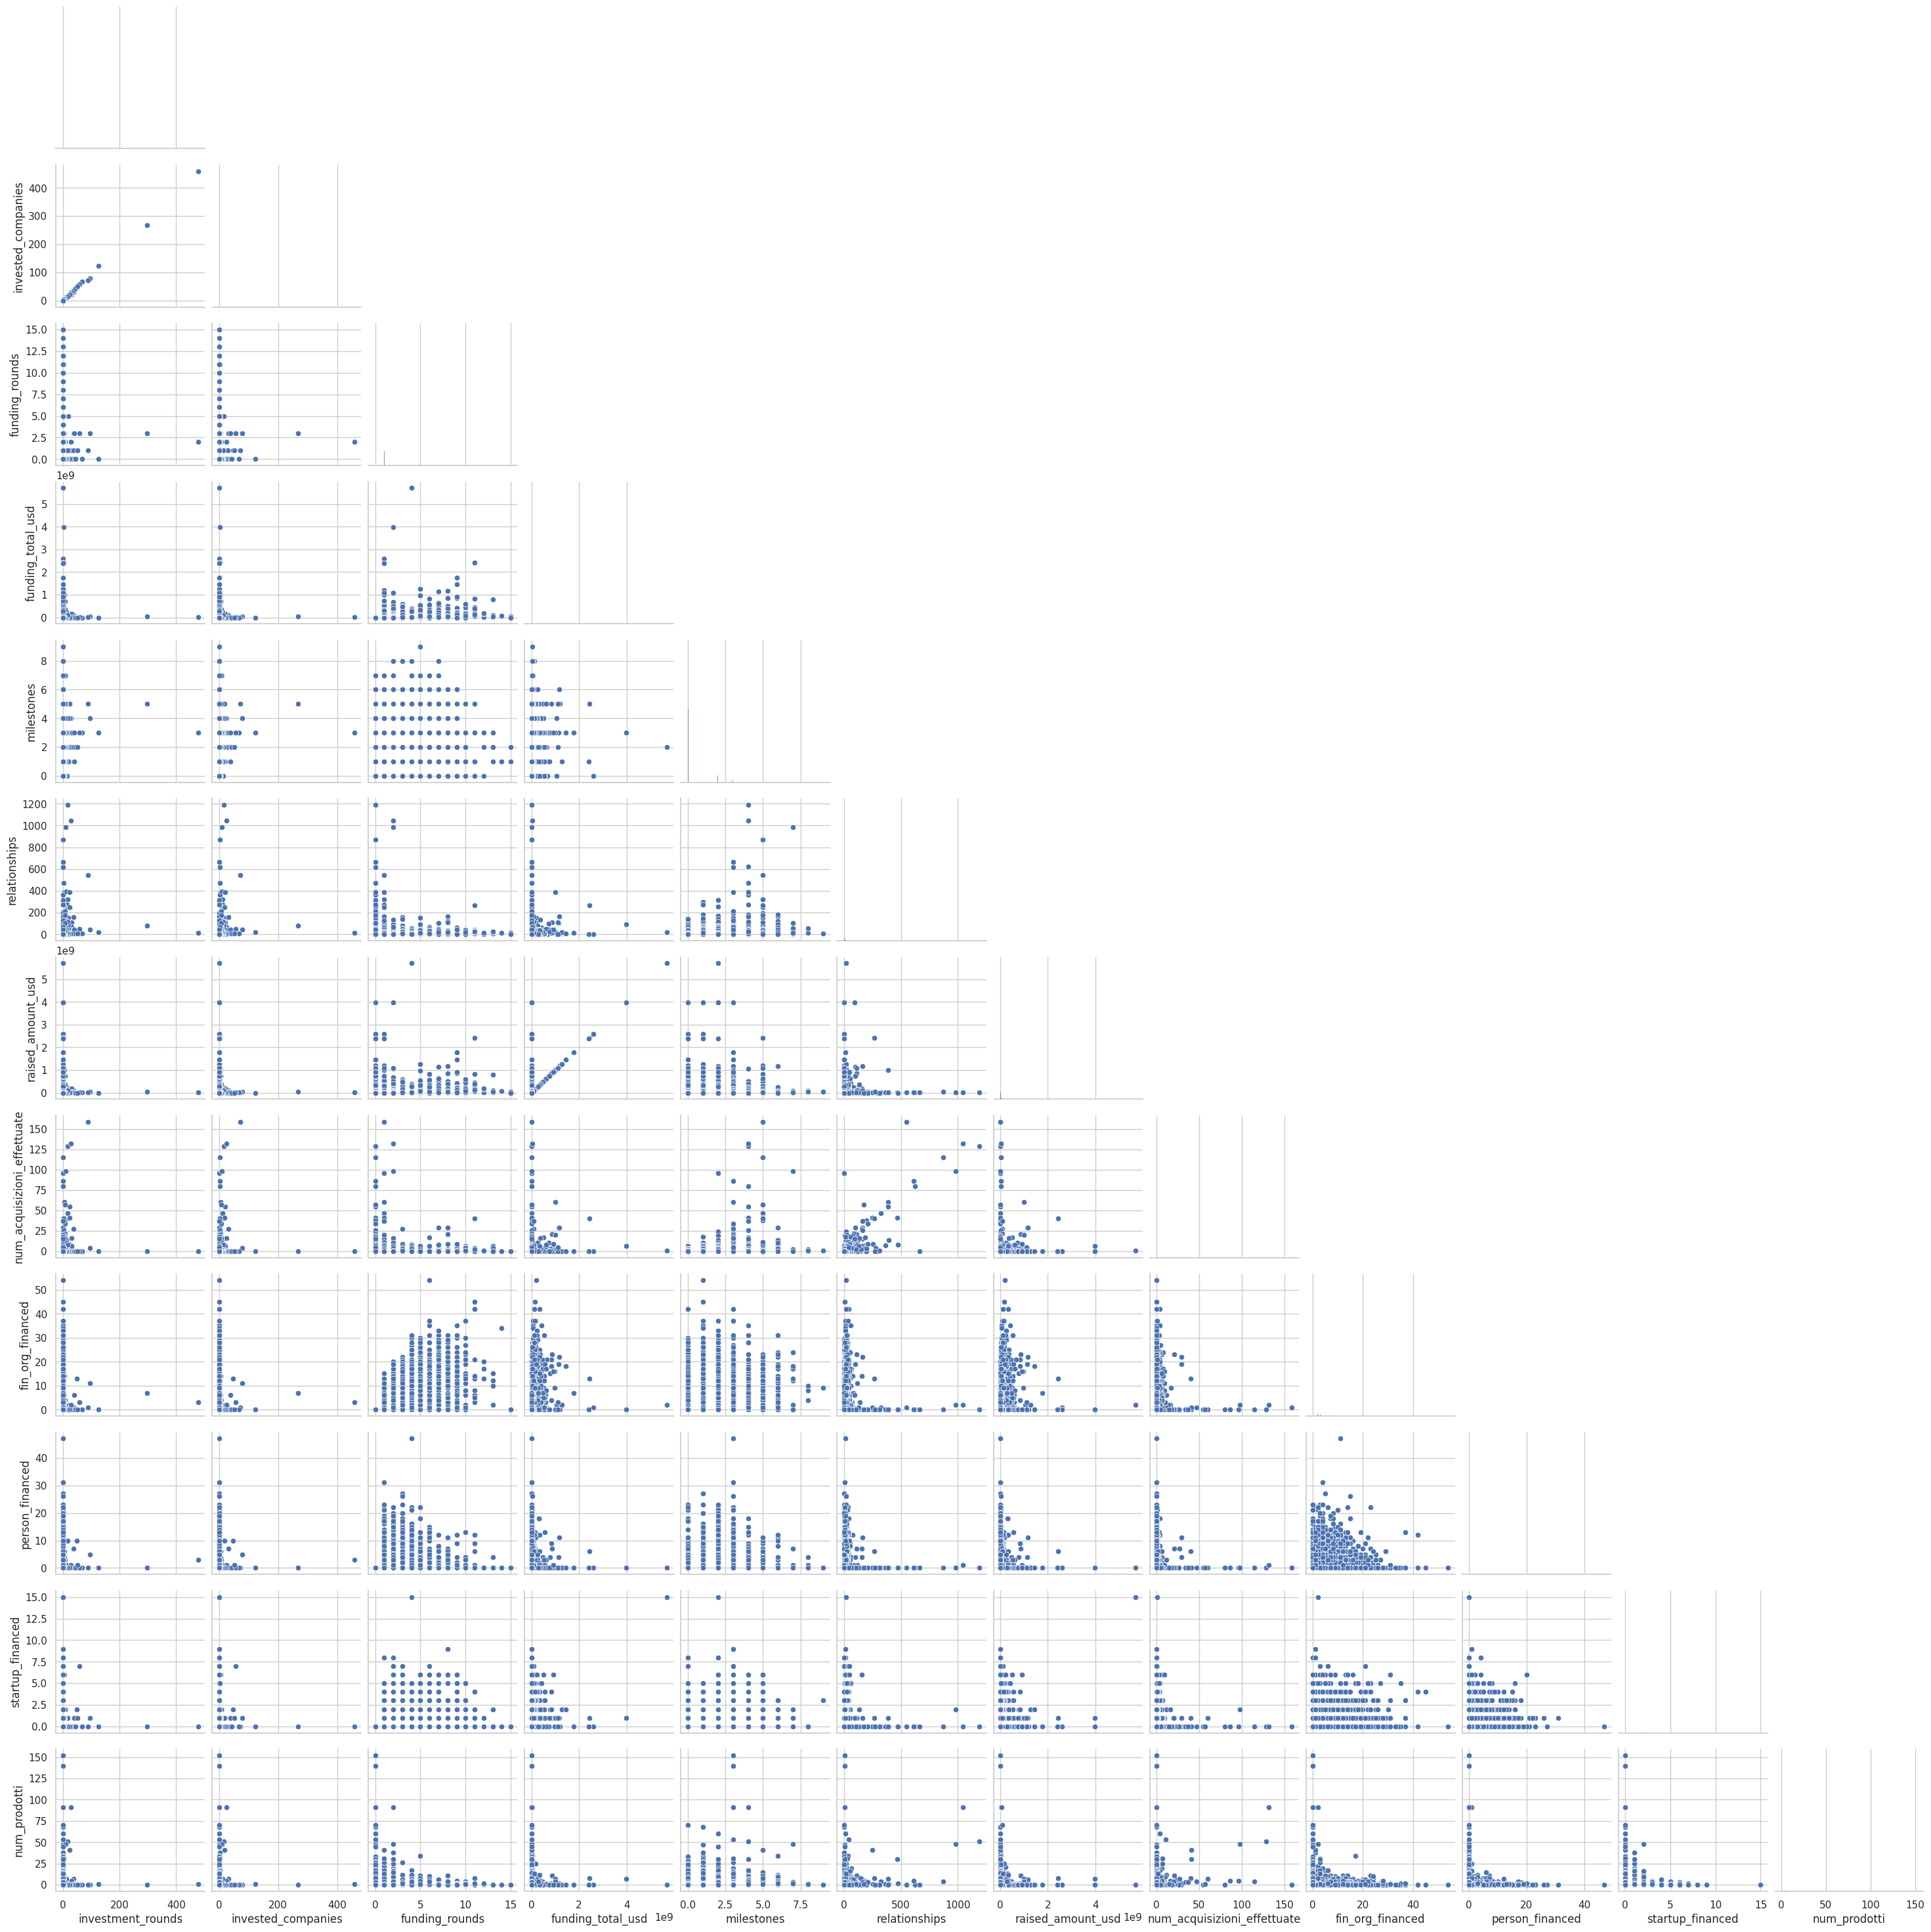

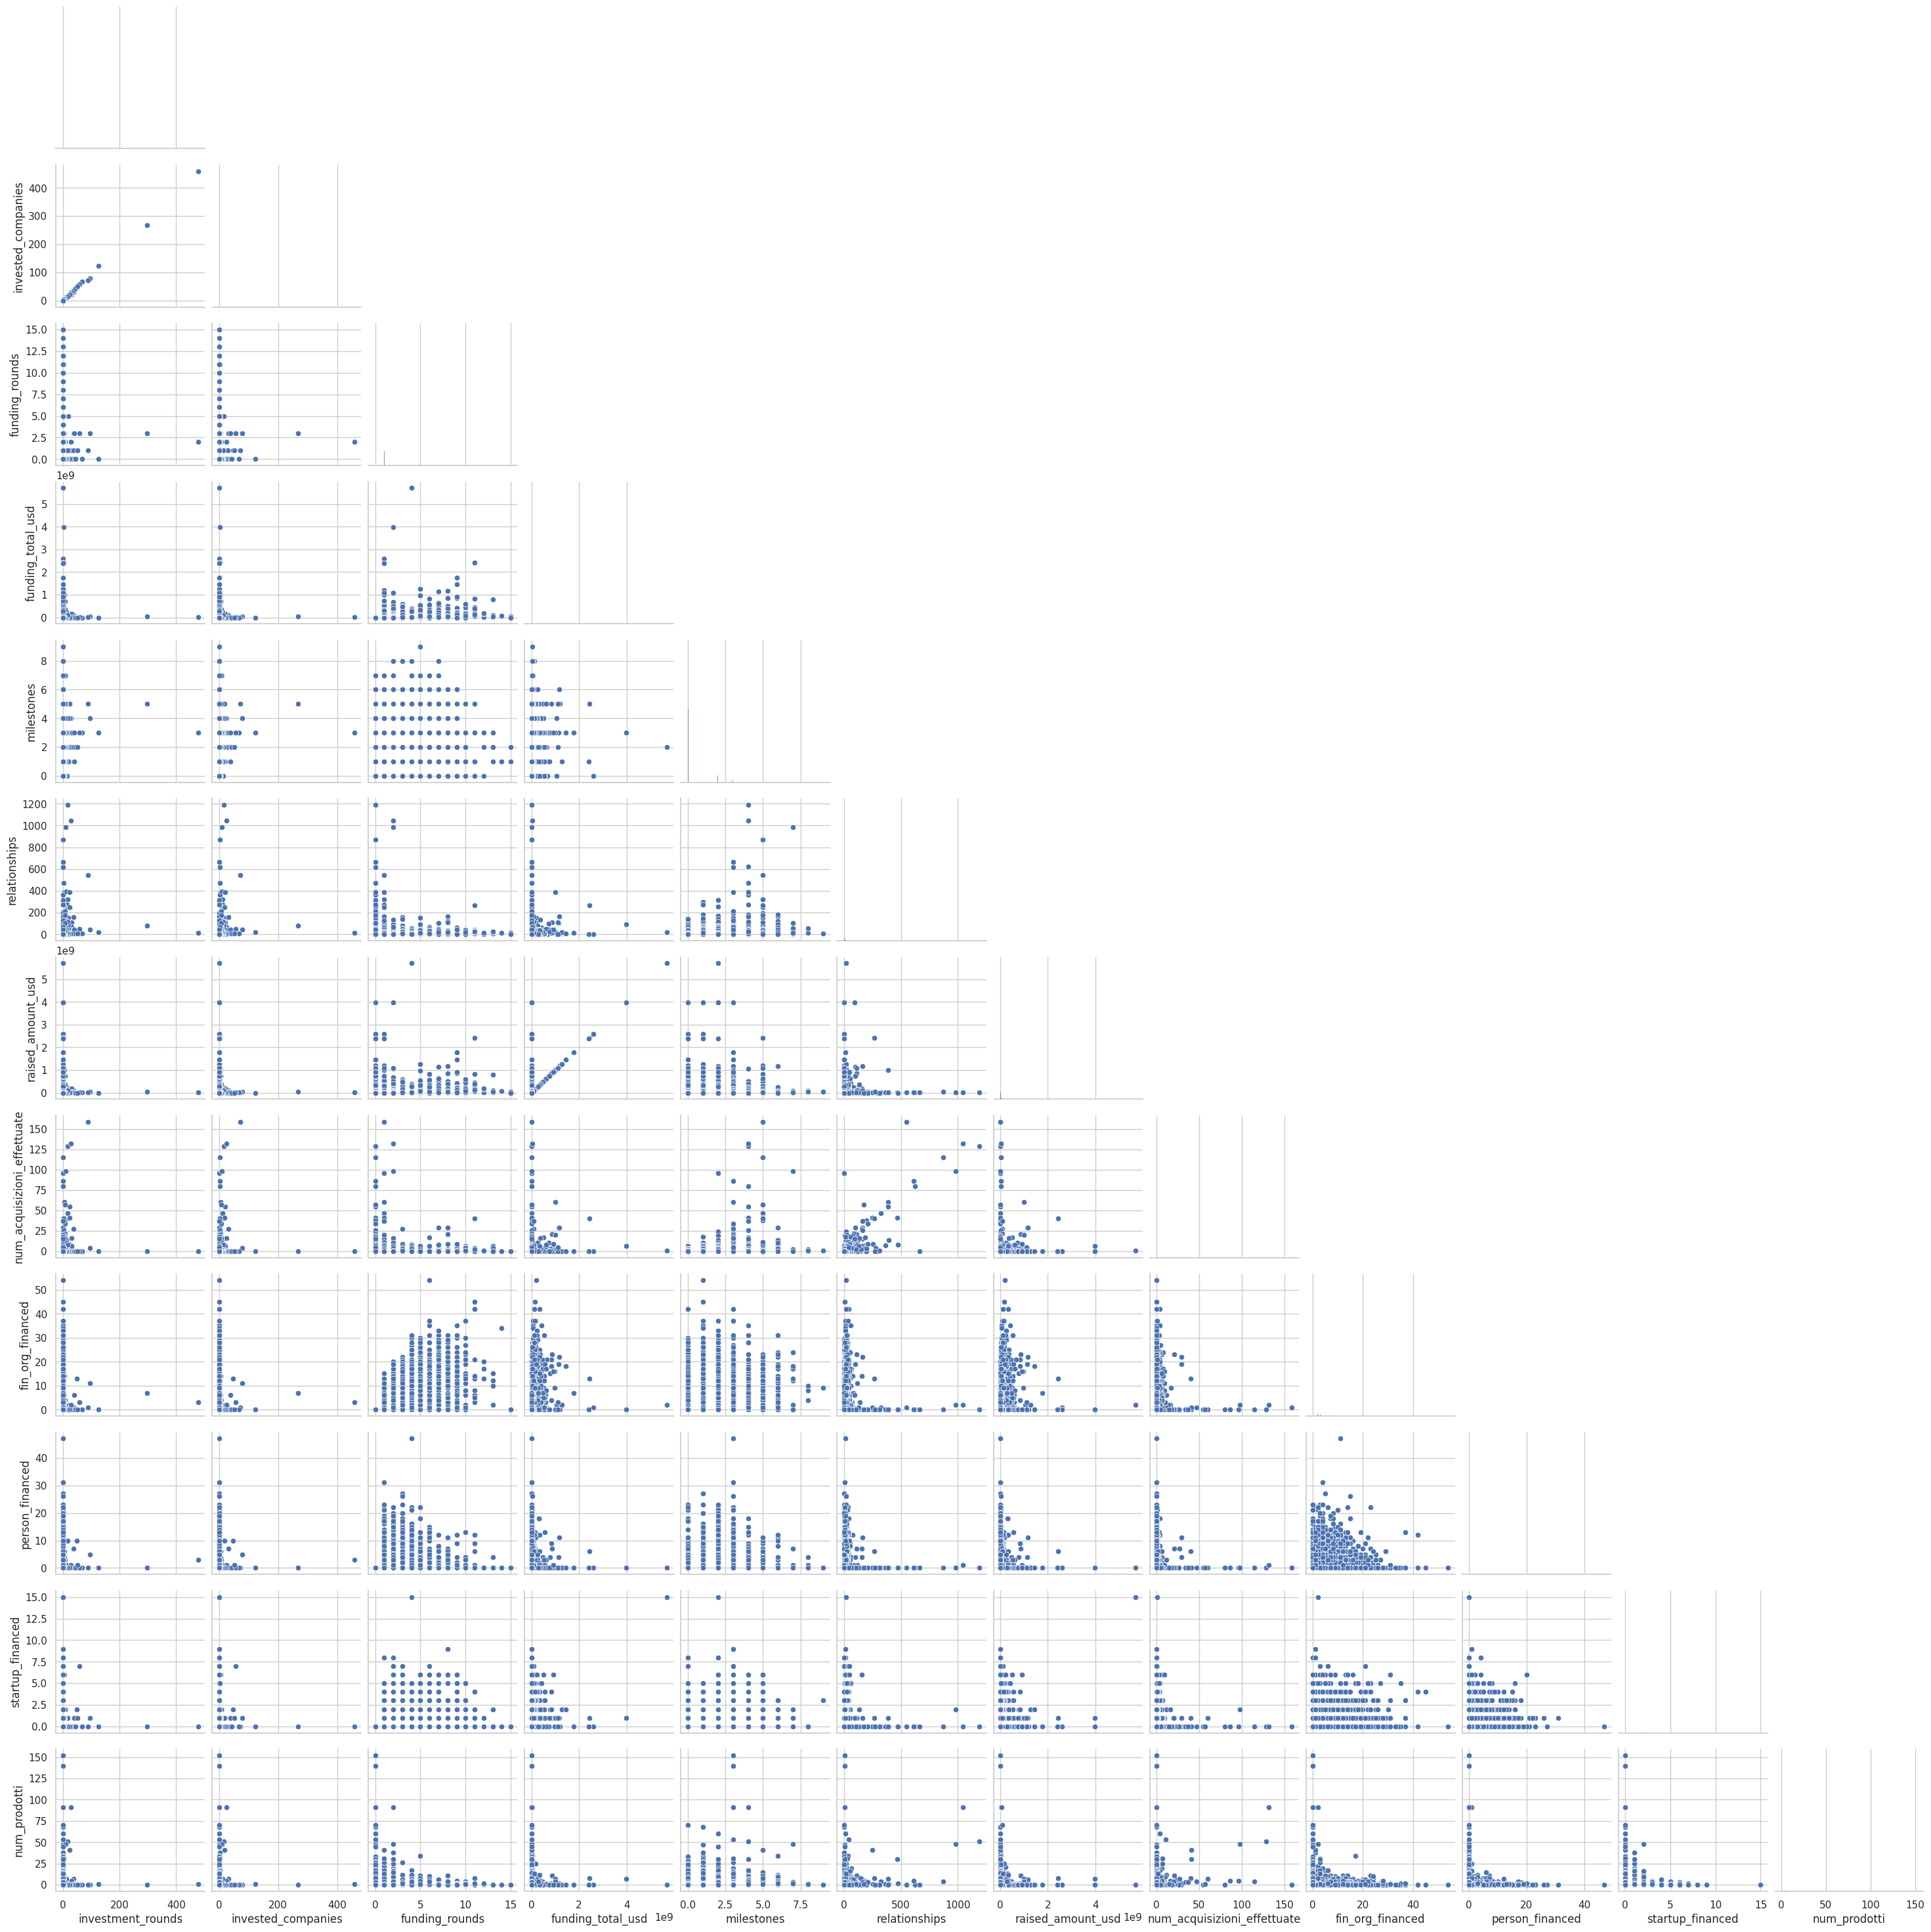

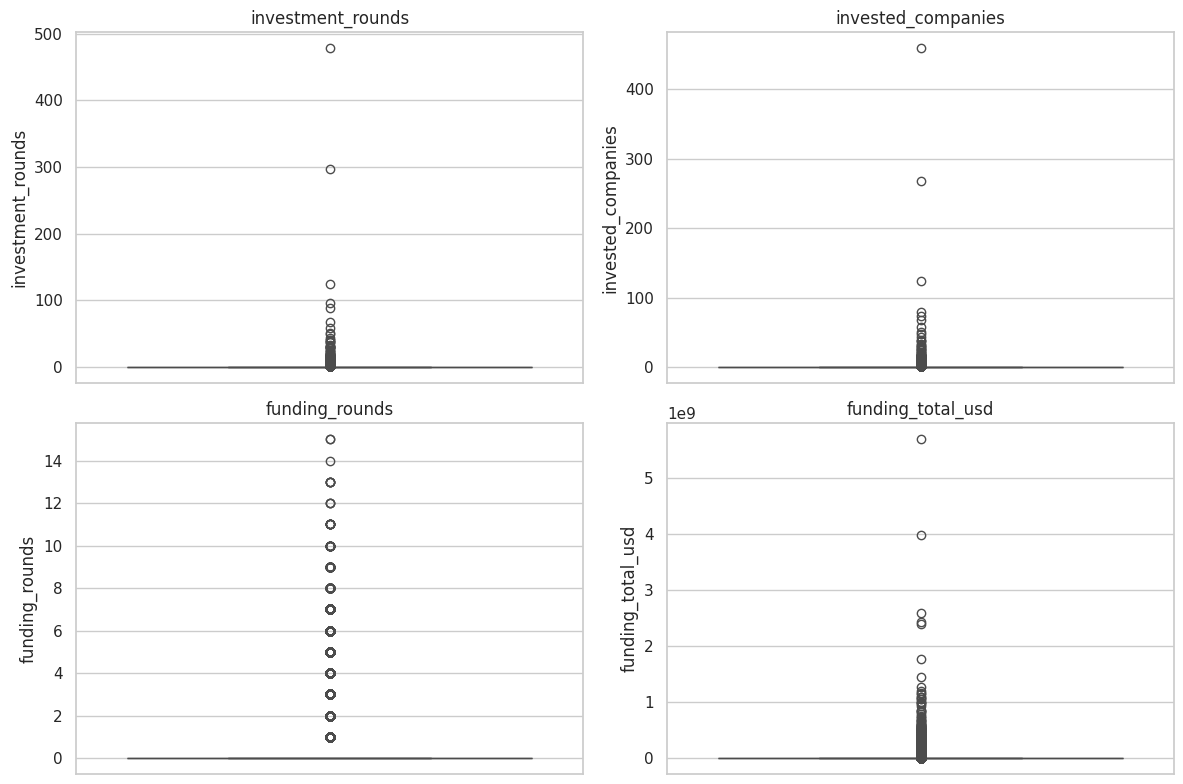

In [ ]:
# Pairplot (may be slow for large datasets) - use a sample if necessary
sns.set(style='whitegrid', context='notebook')
try:
    if 'species' in df.columns:
        sns.pairplot(df, vars=numeric_features, hue='species', corner=True)
    else:
        sns.pairplot(df, vars=numeric_features, corner=True)
    plt.show()
except Exception as e:
    print('Pairplot failed (headless environment?):', e)

# Boxplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for ax, col in zip(axes.flatten(), numeric_features):
    if 'species' in df.columns:
        sns.boxplot(x=df['species'], y=df[col], ax=ax)
    else:
        sns.boxplot(y=df[col], ax=ax)
    ax.set_title(col)
plt.tight_layout()
plt.show()

PCA explained variance ratios: [0.22593332 0.17189686 0.13116196]


PCA explained variance ratios: [0.22593332 0.17189686 0.13116196]


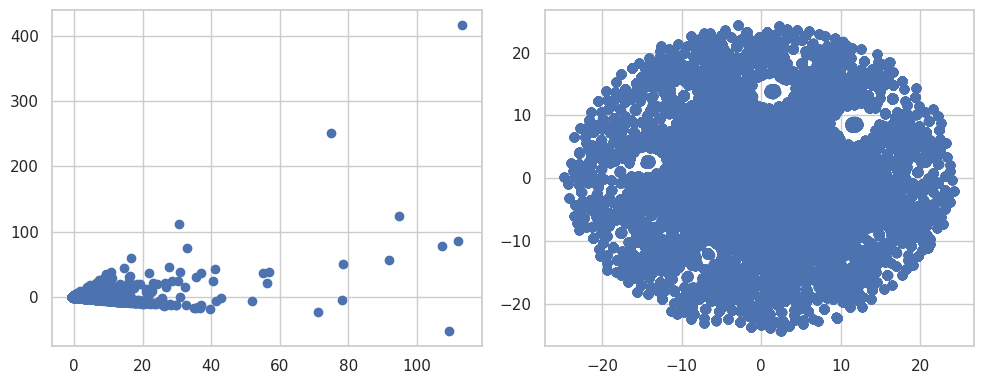

In [ ]:
# PCA
pca = PCA(n_components=3, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)
print('PCA explained variance ratios:', pca.explained_variance_ratio_)

# UMAP
reducer = umap.UMAP(n_components=2, random_state=RANDOM_STATE)
X_umap = reducer.fit_transform(X_scaled)

# Save transformers
joblib.dump(pca, 'artifacts/pca.joblib')
joblib.dump(reducer, 'artifacts/umap.joblib')

# Visualize PCA and UMAP colored by true species (if available)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
if 'species' in df.columns:
    sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df['species'], palette='tab10')
    plt.title('PCA (2 components)')
else:
    plt.scatter(X_pca[:,0], X_pca[:,1])

plt.subplot(1,2,2)
if 'species' in df.columns:
    sns.scatterplot(x=X_umap[:,0], y=X_umap[:,1], hue=df['species'], palette='tab10')
    plt.title('UMAP (2D)')
else:
    plt.scatter(X_umap[:,0], X_umap[:,1])

plt.tight_layout()
plt.show()

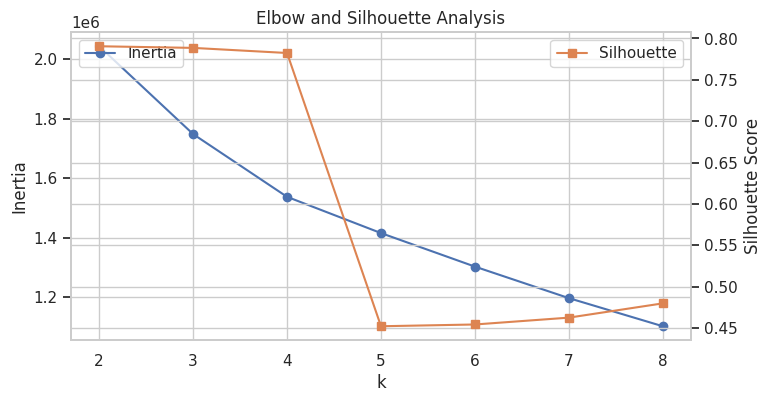

Inertias: [2043935.2629606733, 1748156.1262603267, 1536977.0279475523, 1414938.7568473448, 1302059.7129680528, 1195948.0187231991, 1101300.914969681]
Silhouette scores: [0.790535259468725, 0.7885489275345807, 0.7823801779707672, 0.45209929746704847, 0.45423466046734645, 0.46251216276353463, 0.47976082543978027]


In [ ]:
from tqdm.notebook import trange

ks = list(range(2,9))
inertias = []
sil_scores = []
for k in ks:
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))

# Plot
fig, ax1 = plt.subplots(figsize=(8,4))
ax1.plot(ks, inertias, marker='o', label='Inertia')
ax1.set_xlabel('k')
ax1.set_ylabel('Inertia')
ax2 = ax1.twinx()
ax2.plot(ks, sil_scores, marker='s', color='C1', label='Silhouette')
ax2.set_ylabel('Silhouette Score')
plt.title('Elbow and Silhouette Analysis')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

print('Inertias:', inertias)
print('Silhouette scores:', sil_scores)

[INFO] Using subsample of 2000/196498 points for dendrogram.


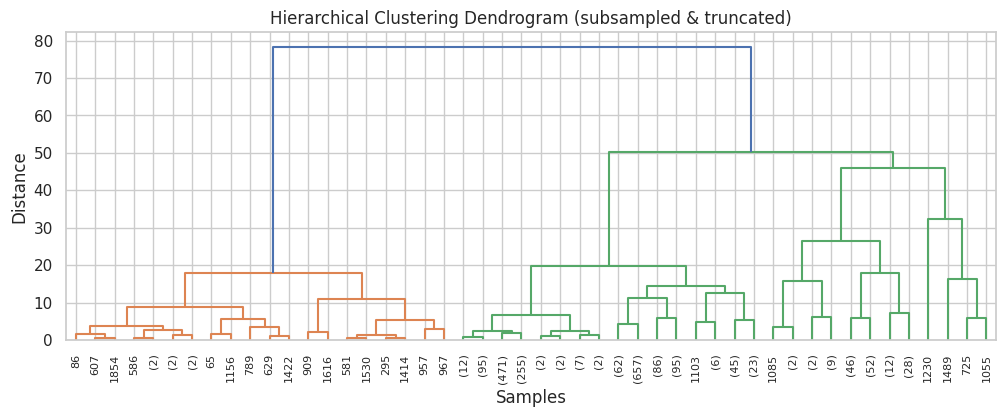

Top-level cluster counts (propagated): [  2030 178796  15672]


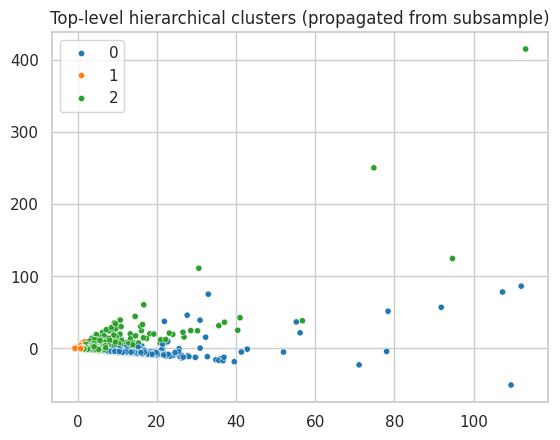

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics import pairwise_distances_argmin_min

# --- Subsample for dendrogram visualization ---
sample_size = 2000  # you can reduce this if your RAM is limited
if X_pca.shape[0] > sample_size:
    sample_idx = np.random.choice(X_pca.shape[0], size=sample_size, replace=False)
    X_sub = X_pca[sample_idx]
    print(f"[INFO] Using subsample of {sample_size}/{X_pca.shape[0]} points for dendrogram.")
else:
    X_sub = X_pca
    sample_idx = np.arange(X_pca.shape[0])
    print("[INFO] Dataset small enough — using all points.")

# --- Perform hierarchical clustering on subsample ---
Z = linkage(X_sub, method='ward')

# --- Plot truncated dendrogram ---
plt.figure(figsize=(12, 4))
dendrogram(Z, truncate_mode='level', p=5)
plt.title('Hierarchical Clustering Dendrogram (subsampled & truncated)')
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.show()

# --- Choose number of top-level clusters (you can change this) ---
n_top = 3
top_labels_sub = fcluster(Z, t=n_top, criterion='maxclust')

# --- Compute centroids of clusters in the subsample ---
centroids = np.array([
    X_sub[top_labels_sub == i].mean(axis=0)
    for i in np.unique(top_labels_sub)
])

# --- Assign every point in the full dataset to the nearest centroid ---
top_labels_full, _ = pairwise_distances_argmin_min(X_pca, centroids)

# --- Attach labels to DataFrame ---
df['top_cluster'] = top_labels_full

# --- Print cluster size statistics ---
print('Top-level cluster counts (propagated):', np.bincount(top_labels_full))

# --- Visualize clustering result on full PCA space ---
sns.scatterplot(
    x=X_pca[:,0],
    y=X_pca[:,1],
    hue=top_labels_full,
    palette='tab10',
    s=20
)
plt.title('Top-level hierarchical clusters (propagated from subsample)')
plt.show()


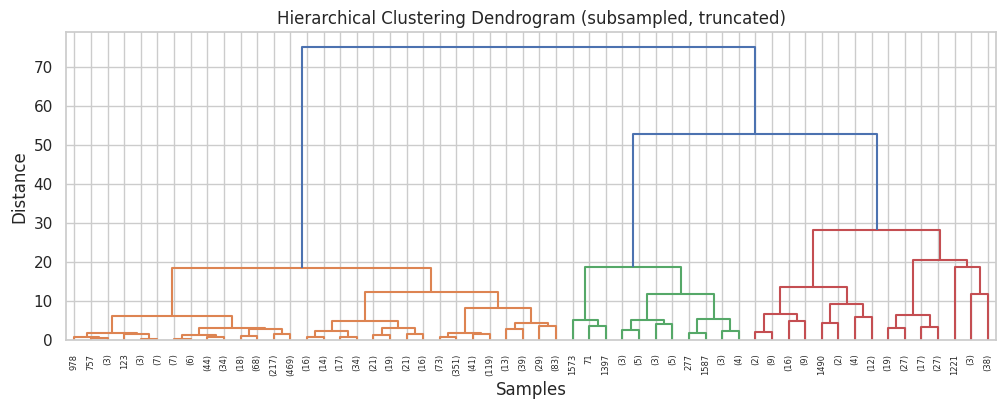

Top-level cluster counts: [     0 175345   2201  18952]


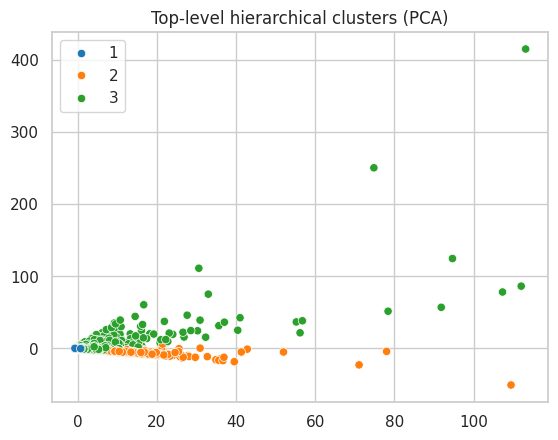

Per-top-cluster meta: {np.int32(1): {'k_sub': 5, 'silhouette': 0.6666246120908902}, np.int32(2): {'k_sub': 2, 'silhouette': 0.7471356956184194}, np.int32(3): {'k_sub': 2, 'silhouette': 0.9676503437409207}}
Sample multi-level labels: multi_label
H1-K0    84448
H1-K3    69490
H3-K0    18943
H1-K2    13530
H1-K4     5684
Name: count, dtype: int64


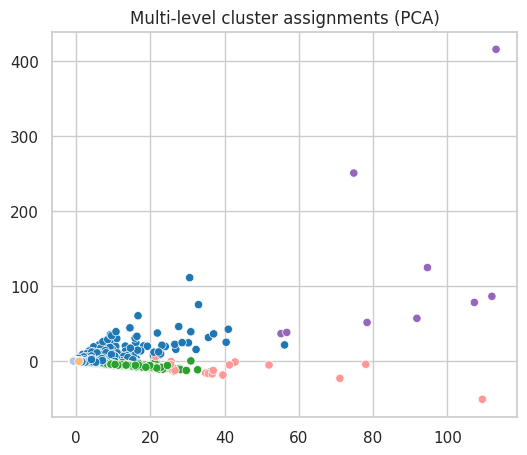

In [ ]:
# === Hierarchical Clustering with Subsample (Memory-safe version) ===
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1️⃣ Subsample for hierarchical clustering ---
subsample = min(2000, X_pca.shape[0])  # limit to 2k samples
idx_sub = np.random.choice(X_pca.shape[0], subsample, replace=False)
X_sub = X_pca[idx_sub]

# --- 2️⃣ Compute linkage on subsample only ---
Z = linkage(X_sub, method='ward')

# Plot dendrogram
plt.figure(figsize=(12, 4))
dendrogram(Z, truncate_mode='level', p=5)
plt.title('Hierarchical Clustering Dendrogram (subsampled, truncated)')
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.show()

# --- 3️⃣ Cut the dendrogram to get n_top clusters on subsample ---
n_top = 3
sub_labels = fcluster(Z, t=n_top, criterion='maxclust')

# --- 4️⃣ Train KNN to assign cluster labels to all samples ---
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_sub, sub_labels)
top_labels = knn.predict(X_pca)  # assign full dataset labels
print('Top-level cluster counts:', np.bincount(top_labels))

# --- 5️⃣ Attach to DataFrame and visualize ---
df['top_cluster'] = top_labels
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=top_labels, palette='tab10')
plt.title('Top-level hierarchical clusters (PCA)')
plt.show()

# --- 6️⃣ Refine each top-level cluster with KMeans ---
final_labels = np.full(shape=(X_scaled.shape[0],), fill_value='-', dtype=object)
cluster_meta = {}

for c in np.unique(top_labels):
    idx = np.where(top_labels == c)[0]
    X_sub_cluster = X_scaled[idx]

    # Optional subsample for silhouette search
    if len(idx) > 1000:
        idx_small = np.random.choice(len(idx), 1000, replace=False)
        X_small = X_sub_cluster[idx_small]
    else:
        X_small = X_sub_cluster

    chosen_k = 2
    best_score = -1
    best_km = None
    best_labels_sub = None

    for k_sub in range(2, min(6, len(X_small))):
        km = KMeans(n_clusters=k_sub, random_state=RANDOM_STATE, n_init=10)
        labels_sub = km.fit_predict(X_small)
        if len(set(labels_sub)) <= 1:
            continue
        score = silhouette_score(X_small, labels_sub)
        if score > best_score:
            best_score = score
            chosen_k = k_sub
            best_km = km
            best_labels_sub = km.predict(X_sub_cluster)

    # Assign multi-level labels
    for i, sub in enumerate(best_labels_sub):
        final_labels[idx[i]] = f'H{c}-K{sub}'
    cluster_meta[c] = {'k_sub': chosen_k, 'silhouette': best_score}

df['multi_label'] = final_labels
print('Per-top-cluster meta:', cluster_meta)
print('Sample multi-level labels:', df['multi_label'].value_counts().head())

# --- 7️⃣ Visualize final multi-level clusters ---
plt.figure(figsize=(6,5))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df['multi_label'], palette='tab20', legend=False)
plt.title('Multi-level cluster assignments (PCA)')
plt.show()


Overall silhouette (multi-level, subsampled): 0.5706256628446038
Davies-Bouldin index (subsampled): 1.8010490225389748


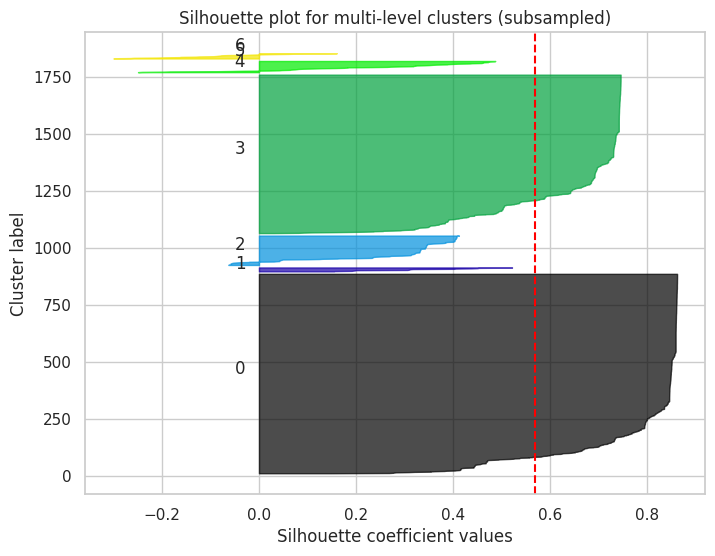

In [ ]:
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score, adjusted_rand_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.cm as cm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# === Encode labels numerically ===
le = LabelEncoder()
ml_numeric = le.fit_transform(df['multi_label'])

# === Subsample for metrics & silhouette plot ===
subsample = min(2000, X_scaled.shape[0])
idx_eval = np.random.choice(X_scaled.shape[0], subsample, replace=False)
X_eval = X_scaled[idx_eval]
labels_eval = ml_numeric[idx_eval]

# === Compute overall metrics on subsample ===
sil_overall = silhouette_score(X_eval, labels_eval)
db = davies_bouldin_score(X_eval, labels_eval)
print('Overall silhouette (multi-level, subsampled):', sil_overall)
print('Davies-Bouldin index (subsampled):', db)

# === Compare with ground truth if available ===
if 'species' in df.columns:
    ari = adjusted_rand_score(df['species'].astype(str), ml_numeric)
    print('Adjusted Rand Index vs true species:', ari)
    print('\nContingency table:')
    display(pd.crosstab(df['species'], df['multi_label']))

# === Silhouette plot on subsample ===
n_clusters = len(np.unique(labels_eval))
fig, ax1 = plt.subplots(1, 1, figsize=(8, 6))

sample_silhouette_values = silhouette_samples(X_eval, labels_eval)
y_lower = 10
for i in range(n_clusters):
    ith_cluster_silhouette_values = sample_silhouette_values[labels_eval == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7
    )
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

ax1.set_title('Silhouette plot for multi-level clusters (subsampled)')
ax1.set_xlabel('Silhouette coefficient values')
ax1.set_ylabel('Cluster label')
ax1.axvline(x=sil_overall, color='red', linestyle='--')
plt.show()


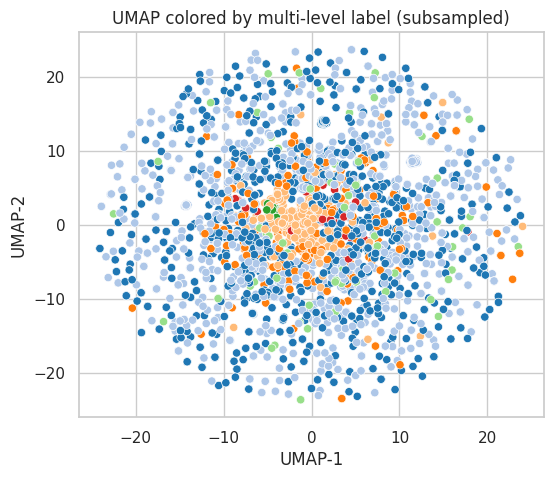

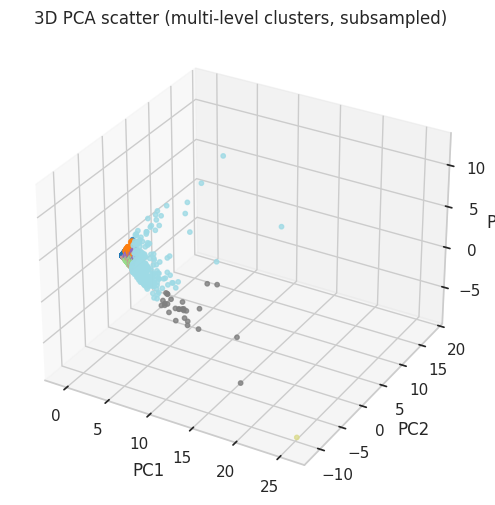

In [ ]:
# === Visualization with Subsample (Cách 3) ===
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# --- Subsample for visualization ---
subsample = min(3000, X_umap.shape[0])  # limit to 3k points for clarity
idx_vis = np.random.choice(X_umap.shape[0], subsample, replace=False)

# --- 2D UMAP colored by multi-level cluster ---
plt.figure(figsize=(6,5))
sns.scatterplot(
    x=X_umap[idx_vis, 0],
    y=X_umap[idx_vis, 1],
    hue=df['multi_label'].iloc[idx_vis],
    palette='tab20',
    legend=False
)
plt.title('UMAP colored by multi-level label (subsampled)')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.show()

# --- 3D PCA scatter ---
subsample_pca = min(3000, X_pca.shape[0])
idx_pca = np.random.choice(X_pca.shape[0], subsample_pca, replace=False)
labels_pca = df['multi_label'].iloc[idx_pca].astype('category').cat.codes

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    X_pca[idx_pca, 0],
    X_pca[idx_pca, 1],
    X_pca[idx_pca, 2],
    c=labels_pca,
    cmap='tab20',
    s=10,
    alpha=0.8
)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.title('3D PCA scatter (multi-level clusters, subsampled)')
plt.show()


In [ ]:
# Save predictions
df.to_csv('artifacts/penguins_with_clusters.csv', index=False)

# Save cluster meta
joblib.dump(cluster_meta, 'artifacts/cluster_meta.joblib')

print('Saved CSV and artifacts to ./artifacts')

# Optionally save KMeans models per top-cluster
# For simplicity, only save the best_km from the last loop; in production we'd save one per top-cluster
try:
    joblib.dump(best_km, 'artifacts/kmeans_example.joblib')
except Exception:
    pass

# List artifacts
print(os.listdir('artifacts'))

Saved CSV and artifacts to ./artifacts
['umap.joblib', 'imputer.joblib', 'penguins_with_clusters.csv', 'scaler.joblib', 'cluster_meta.joblib', 'kmeans_example.joblib', 'pca.joblib']


In [ ]:
# Record versions
import sys
print('python', sys.version)
import sklearn
print('scikit-learn', sklearn.__version__)
import umap
print('umap-learn', umap.__version__)

# Quick checks
assert X_scaled.shape[0] == df.shape[0], 'Mismatch rows between features and df'
assert np.isfinite(X_scaled).all(), 'Non-finite values in scaled features'
assert 'multi_label' in df.columns, 'multi_label missing'
print('Quick checks passed')

# Load artifact and re-run a prediction for first row
imputer2 = joblib.load('artifacts/imputer.joblib')
scaler2 = joblib.load('artifacts/scaler.joblib')
print('Loaded imputer and scaler from artifacts')

# final summary
print('\nNotebook run completed at', datetime.now())

python 3.13.5 | packaged by Anaconda, Inc. | (main, Jun 12 2025, 16:17:47) [GCC 11.2.0]
scikit-learn 1.7.2
umap-learn 0.5.9.post2
Quick checks passed
Loaded imputer and scaler from artifacts

Notebook run completed at 2025-10-29 12:28:07.406699
